Given the same ligand, can you do arithmetic 
(protein-ligand complex embedding) - (protein embedding) + (new protein embedding) = (new protein-ligand complex embedding) ?

In [1]:
import os
import sys

# Get the current notebook's directory
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(os.path.dirname(current_directory))

# Add the parent directory to the module search path
sys.path.insert(0, parent_directory)
print(parent_directory)

/n/holylabs/LABS/mzitnik_lab/Users/afang/GET


In [2]:
from data.converter.pdb_to_list_blocks import pdb_to_list_blocks
from data.converter.sm_pdb_to_blocks import sm_pdb_to_blocks
import data.dataset
from data.atom3d_dataset import LBADataset
import models
import torch
from trainers.abs_trainer import Trainer
import importlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from models import DenoisePretrainModel, AffinityPredictor
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import itertools
import random
import scipy
from torch_scatter import scatter_sum

/n/home13/afang/.conda/envs/interactenv1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import importlib
importlib.reload(data.dataset)
from data.dataset import VOCAB
from data.dataset import blocks_interface, blocks_to_data
from data.dataset import BlockGeoAffDataset, PDBBindBenchmark, DynamicBatchWrapper

In [4]:
dataset = LBADataset("/n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train")

fragmentation False
2024-02-22 10:25:54::INFO::Loading preprocessed data from /n/holylabs/LABS/mzitnik_lab/Users/afang/GET/datasets/LBA/split-by-sequence-identity-30/train.LBADataset_processed.pkl...


In [5]:
with open("adp_pdbs.txt", "r") as f:
    proteins = f.read().split("\n")
len(set(proteins))

31

In [6]:
protein_dataset = []
for d in dataset:
    if d["id"] not in proteins:
        continue
    protein_dataset.append(d)
proteins = [d["id"] for d in protein_dataset]
len(proteins)

28

In [7]:
pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_112/checkpoint/epoch144_step61190.ckpt"

# NOTE if you want to load a pretrained checkpoint i.e. a Denoise Pretrain Model you need to turn it into an AffinityPredictor
# this is so that the perturb function is turned off otherwise it will perturb the input and the output will be garbage

# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/pretrain/models/InteractNN-global/version_76/checkpoint/epoch8_step690593.ckpt" # pretrained only
# pretrain_ckpt = "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_104/checkpoint/epoch129_step54860.ckpt" # partial finetuned from the 4 day long pretraining run with global nodes
# "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_98/checkpoint/epoch109_step46420.ckpt" # finetuned from the 4 day long pretraining run
# "/n/holyscratch01/mzitnik_lab/afang/GET/datasets/LBA/split-by-sequence-identity-30/models/InteractNN/version_89/checkpoint/epoch69_step29470.ckpt" # finetuned from QBioLIP
model = torch.load(pretrain_ckpt, map_location='cpu')
model = model.to("cuda")

In [8]:
embeddings = {}
ligand_embeddings = {}
pocket_embeddings = {}
pred_labels = {}
true_labels = {}
batch_size = 8
for i in range(0, len(protein_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch = LBADataset.collate_fn(protein_dataset[i:i+batch_size])
        pdb_ids = [d["id"] for d in protein_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")
        if type(model) is AffinityPredictor:
            pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        else:
            output = model(
                Z=minibatch['X'], B=minibatch['B'], A=minibatch['A'],
                atom_positions=minibatch['atom_positions'],
                block_lengths=minibatch['block_lengths'],
                lengths=minibatch['lengths'],
                segment_ids=minibatch['segment_ids'],
                label=None
            )
            pred_binding_affinity = [None for _ in range(len(pdb_ids))]
        
        batch_id = torch.zeros_like(minibatch["segment_ids"])  # [Nb]
        batch_id[torch.cumsum(minibatch["lengths"], dim=0)[:-1]] = 1
        batch_id.cumsum_(dim=0)  # [Nb], item idx in the batch
        for idx, pdb_id in enumerate(pdb_ids):
            embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()
            ligand_embeddings[pdb_id] = output.block_repr[torch.logical_and(batch_id == idx, minibatch["segment_ids"] == 1)].cpu().numpy().mean(axis=0)
            pocket_embeddings[pdb_id] = output.block_repr[torch.logical_and(batch_id == idx, minibatch["segment_ids"] == 0)].cpu().numpy().mean(axis=0)
            pred_labels[pdb_id] = pred_binding_affinity[idx].cpu().numpy() if pred_binding_affinity[idx] is not None else None
            true_labels[pdb_id] = minibatch["label"][idx].cpu().numpy()

In [9]:
pocket_only_embeddings = {}

for i in range(0, len(protein_dataset), batch_size):
    model.eval()
    with torch.no_grad():
        minibatch_ = [BlockGeoAffDataset.filter_for_segment(d, 0) for d in protein_dataset[i:i+batch_size]]
        minibatch = LBADataset.collate_fn(minibatch_)
        pdb_ids = [d["id"] for d in protein_dataset[i:i+batch_size]]
        minibatch = Trainer.to_device(minibatch, "cuda")

        if type(model) is AffinityPredictor:
            pred_binding_affinity, output = model.infer(minibatch, extra_info=True)
        else:
            output = model(
                Z=minibatch['X'], B=minibatch['B'], A=minibatch['A'],
                atom_positions=minibatch['atom_positions'],
                block_lengths=minibatch['block_lengths'],
                lengths=minibatch['lengths'],
                segment_ids=minibatch['segment_ids'],
                label=None
            )
            pred_binding_affinity = [None for _ in range(len(pdb_ids))]
        for idx, pdb_id in enumerate(pdb_ids):
            pocket_only_embeddings[pdb_id] = output.graph_repr[idx].cpu().numpy()

In [10]:
len(pocket_only_embeddings)

28

In [18]:
pairs = list(itertools.combinations(pocket_only_embeddings.keys(), 2))
dist_construct = []
dist_rand = []
dist_pockets = []
for p1, p2 in pairs:
    p1_cmplx = embeddings[p1]
    p2_cmplx = embeddings[p2]
    p1_prot = pocket_only_embeddings[p1]
    p2_prot = pocket_only_embeddings[p2]

    p1_cmplx_construct = p1_cmplx - p1_prot + p2_prot
    p2_cmplx_construct = p2_cmplx - p2_prot + p1_prot

    rand_p1_cmplx = np.random.normal(size=p1_cmplx.shape)
    rand_p2_cmplx = np.random.normal(size=p2_cmplx.shape)

    # rand_p1_cmplx = np.mean(list(embeddings.values()), axis=0)
    # rand_p2_cmplx = np.mean(list(embeddings.values()), axis=0)

    dist_construct.append(np.linalg.norm(p1_cmplx_construct - p1_cmplx))
    dist_construct.append(np.linalg.norm(p2_cmplx_construct - p2_cmplx))
    dist_rand.append(np.linalg.norm(p1_cmplx - rand_p1_cmplx))
    dist_rand.append(np.linalg.norm(p2_cmplx - rand_p2_cmplx))
    dist_pockets.append(np.linalg.norm(p1_prot - p2_prot))
                          

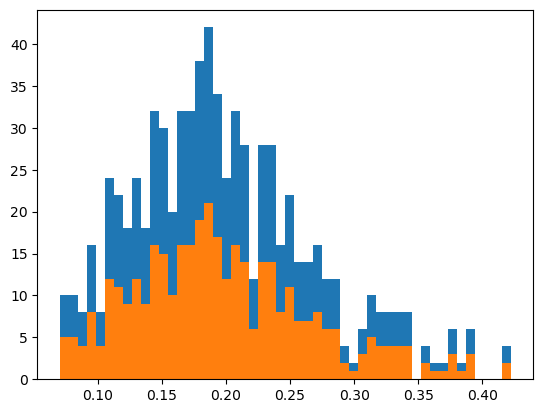

In [19]:
plt.hist(dist_construct, bins=50)
# plt.hist(dist_rand, bins=50)
plt.hist(dist_pockets, bins=50)
plt.show()